# About data_connector

This notebook pulls information from different sources of data (log, session) to connect student's data across types.
The end goal is a connection between student id and log files, survey data, and worksheet data.

In [1]:
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import matplotlib
import matplotlib.pyplot as plt
#utils.py is where all our custorm functions live is we set an autoreload on it.
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing 
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 20, 7
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)

## Overview
We have log data, survey data, worksheet data and lots of metadata. We have to connect them all! First we must build the right metadata files.
Let's start by connecting log data files to session data, mapping each log data to a student and to a session using dates and times.

## 1. Connecting log data to session data
We grab the parsing file reports and the session data

In [2]:
df_beers = get_latest_parsing_report('beers')
df_beers = df_beers[df_beers.studentid != 'student1']
df_beers.studentid = df_beers.studentid.astype(int)
df_caps = get_latest_parsing_report('capacitor')
df_caps.studentid = df_caps.studentid.astype(int)
df_sessions = get_session_data()

Captured beers parsing report that was parsed on 2017-11-24_16.04.04
Captured capacitor parsing report that was parsed on 2017-11-27_09.33.22


In [3]:
df_sessions

,session number,date,number of students from sign out sheet,start time,end time,wave,ran study,supported,keep
0,1,2017-1-13,5,13,15,1,Jon,Sarah,drop
1,2,2017-1-17,14,11,13,1,Jon,Sarah,keep
2,3,2017-1-17,18,15,17,1,Sarah,Jon,keep
3,4,2017-1-19,5,9,11,1,Sarah,Jon,keep
4,5,2017-1-19,18,13,15,1,Jon,Sarah,keep
5,6,2017-1-20,10,11,13,1,Sarah,Jon,keep
6,7,2017-1-20,18,15,17,1,Jon,Sarah,keep
7,8,2017-1-23,7,15,17,1,Sarah,Jon,keep
8,9,2017-1-27,12,13,15,1,Sarah,Jon,keep
9,10,2017-3-20,15,15,17,2,Sarah,Jon,keep


In [4]:
def get_session_times(df):
    times = {}
    for i,row in df.iterrows():
        day,start,end,session = row['date'],str(row['start time']),str(row['end time']),int(row['session number'])
        date = (day+'_'+start+".00.00",day+'_'+end+".00.00")
        times[session]=date
    return times
session_times = get_session_times(df_sessions)
print session_times

{1: ('2017-1-13_13.00.00', '2017-1-13_15.00.00'), 2: ('2017-1-17_11.00.00', '2017-1-17_13.00.00'), 3: ('2017-1-17_15.00.00', '2017-1-17_17.00.00'), 4: ('2017-1-19_9.00.00', '2017-1-19_11.00.00'), 5: ('2017-1-19_13.00.00', '2017-1-19_15.00.00'), 6: ('2017-1-20_11.00.00', '2017-1-20_13.00.00'), 7: ('2017-1-20_15.00.00', '2017-1-20_17.00.00'), 8: ('2017-1-23_15.00.00', '2017-1-23_17.00.00'), 9: ('2017-1-27_13.00.00', '2017-1-27_15.00.00'), 10: ('2017-3-20_15.00.00', '2017-3-20_17.00.00'), 11: ('2017-3-21_17.00.00', '2017-3-21_19.00.00'), 12: ('2017-3-22_11.00.00', '2017-3-22_13.00.00'), 13: ('2017-3-22_15.00.00', '2017-3-22_17.00.00'), 14: ('2017-3-23_13.00.00', '2017-3-23_15.00.00'), 15: ('2017-3-28_15.00.00', '2017-3-28_17.00.00')}


In [5]:
def convert_from_unix_time(t):
    ''' Take a unix time stamp in milliseconds and convert to date and time'''
    return datetime.datetime.fromtimestamp(int(t)/1000.0).strftime('%Y-%m-%d_%H.%M.%S')

def convert_to_unix_time(date):
    ''' Take a date and time amd make a unix time stamp'''
    return datetime.datetime.strptime(date, '%Y-%m-%d_%H.%M.%S')

def convert_from_unix_time_plot(t):
    ''' Take a unix time stamp in milliseconds and convert to date and time'''
    return datetime.datetime.fromtimestamp(int(t)/1000.0).strftime('%m-%d_%H')

def extrapolate_session(row):
    session = 'NA'
    date = row['date']
    timestamp = convert_to_unix_time(date)
    for session_number,period in session_times.iteritems():
        t1,t2 = convert_to_unix_time(period[0]),convert_to_unix_time(period[1])
        if timestamp > t1 and timestamp < t2:
            session = session_number   
    return session

df_beers['Session'] = df_beers.apply(extrapolate_session, axis=1)
df_caps['Session'] = df_caps.apply(extrapolate_session, axis=1)

In [6]:
def get_ids_per_session(df):
    ids_per_session = {s:[] for s in set(df['Session'])}
    for i,row in df.iterrows():
        sid,session = str(row['studentid']),row['Session']
        ids_per_session[session].append(sid)
    return ids_per_session

session_beers = get_ids_per_session(df_beers)
session_caps = get_ids_per_session(df_caps)

In [7]:
out =open('session_mega_id_writeout.txt','w')
out.write('\t'.join(['Session','Session time','Expected number (signout sheet)','sim','number of logs','ids']))
for session in sorted(session_times.keys()):
    if session != 'NA':
        expected = str(int(df_sessions[df_sessions['session number']==session]['number of students from sign out sheet']))
    else:
        expected = 'NA'
    period = str(session_times[session][0])+' - '+str(session_times[session][1])
    out.write('\n')
    out.write('\t'.join([str(session),period,expected,'beers',str(len(session_beers[session])), '\t'.join(sorted(session_beers[session]))]))
    out.write('\n')
    out.write('\t'.join(['','','','caps',str(len(session_caps[session])), '\t'.join(sorted(session_caps[session]))]))
    out.write('\n')
out.close()

In [8]:
df_beers.head()

,studentid,sim,date,first time stamp,time in PhET,number of user events,number of model events,number of table errors,number of records,number of gettingValues,number of restores,use table,use graph,use notepad,filename,Session
0,10105157,beers-law-lab,2017-03-22_11.41.17,1490208079592,740.21,2279,988,0,11,11,0,True,True,True,C:\Users\sperez8\Documents\Personal Content\La...,12
1,10127163,beers-law-lab,2017-01-27_13.26.59,1485552421644,971.09,3097,2114,0,23,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,9
2,10192168,beers-law-lab,2017-01-20_16.22.58,1484958181216,458.90,3443,1824,0,27,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,7
3,10232160,beers-law-lab,2017-01-20_15.24.45,1484954687669,811.30,4468,2253,0,8,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,7
4,10375163,beers-law-lab,2017-01-17_16.21.15,1484698878197,602.05,1476,817,0,15,0,0,True,True,False,C:\Users\sperez8\Documents\Personal Content\La...,3


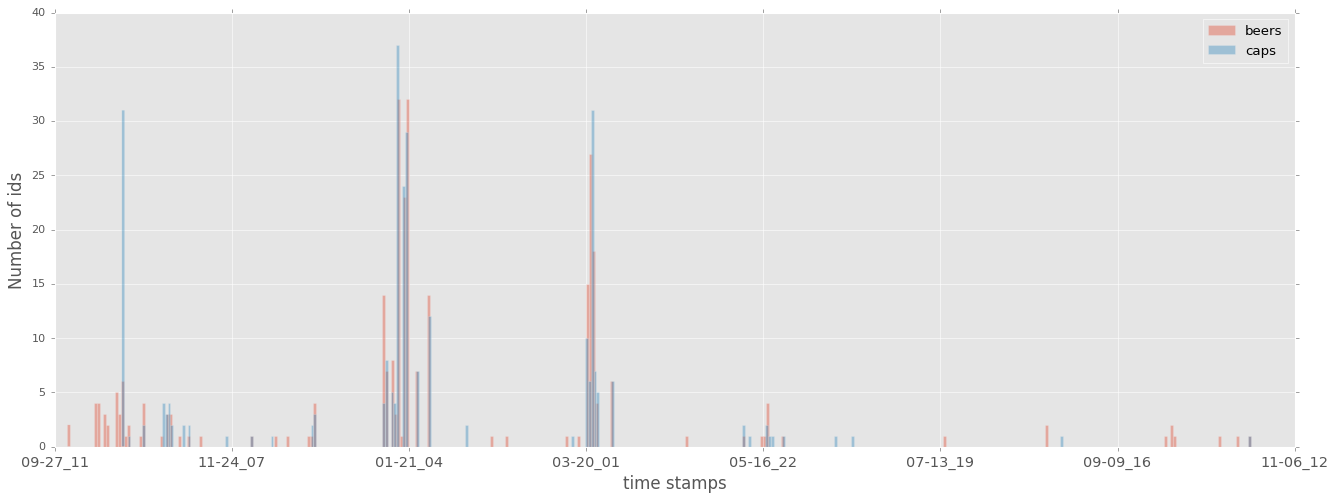

In [9]:
df_beers['first time stamp'].hist(bins=395,alpha=0.4,label='beers')
df_caps['first time stamp'].hist(bins=395,alpha=0.4,label='caps') #about 1 bin per day
# df_sessions['first time stamp'].hist(bins=50,alpha=0.6,label='caps')
ax = plt.subplot()
ax.legend();ax.set_xlabel('time stamps',fontsize=15);ax.set_ylabel('Number of ids',fontsize=15)
xticks = ax.get_xticks()
ax.set_xticklabels([convert_from_unix_time_plot(x) for x in xticks],fontsize=13)

In [10]:
#We can evaluate wither or not we should ignore these when we match their ids to all their log files with dates
# see the file created below "connector_id_to_log_files_and_session.txt"
print set(df_beers[df_beers['Session']=='NA']['studentid'])
print set(df_caps[df_caps['Session']=='NA']['studentid'])

set([12357888, 12344675, 11111111, 12345678, 12341234, 12345667, 12344564, 12344567, 78379161, 14444703, 12345567])
set([12456456, 78379161, 99999999, 12345678, 11111111])


## 2. Find all logs per id
Now that we know what session each id is from, we can start documenting log file pairs to student ids. From the file "*session_mega_id_writeout.xlsx*" it's apparent that some student have several log files. We want to keep track of these to help with log data analysis later.
Ultimately we want a mega metadatafile with the following columns:
* student id
* session
* use in analysis - binary
* id in pre
* id in worksheet
* number of beers files
* number of caps files
* date beers 1
* date beers 2
* date beers 3
* date caps 1
* date caps 2
* date caps 3
* comments/issues

Some columns will be filled using information from the document "*running study and analytics thoughts.gdoc*"

In [11]:
#manual fixing
df_caps.loc[df_caps["studentid"] == 31607164 ,['studentid']] = 36107164
ids = list(set(df_beers.studentid).union(set(df_caps.studentid)))

meta_df = pd.DataFrame(index =ids, columns = ['session','use analysis','number of caps sessions','number of beers sessions','date caps 1','date caps 2','date caps 3','events caps 1','events caps 2','events caps 3','date beers 1','date beers 2','date beers 3','date beers 4','date beers 5','events beers 1','events beers 2','events beers 3','events beers 4','events beers 5','comments'])
meta_df = meta_df.fillna(0)

meta_df[['session']] = meta_df[['session']].astype(int)
meta_df[['use analysis']] = meta_df[['use analysis']].astype(bool)
meta_df[['number of caps sessions']] = meta_df[['number of caps sessions']].astype(int)
meta_df[['number of beers sessions']] = meta_df[['number of beers sessions']].astype(int)
meta_df[['date caps 1']] = meta_df[['date caps 1']].astype(str)
meta_df[['date caps 2']] = meta_df[['date caps 2']].astype(str)
meta_df[['date caps 3']] = meta_df[['date caps 3']].astype(str)
meta_df[['events caps 1']] = meta_df[['events caps 1']].astype(int)
meta_df[['events caps 2']] = meta_df[['events caps 2']].astype(int)
meta_df[['events caps 3']] = meta_df[['events caps 3']].astype(int)
meta_df[['date beers 1']] = meta_df[['date beers 1']].astype(str)
meta_df[['date beers 2']] = meta_df[['date beers 2']].astype(str)
meta_df[['date beers 3']] = meta_df[['date beers 3']].astype(str)
meta_df[['date beers 4']] = meta_df[['date beers 4']].astype(str)
meta_df[['date beers 5']] = meta_df[['date beers 5']].astype(str)
meta_df[['events beers 1']] = meta_df[['events beers 1']].astype(int)
meta_df[['events beers 2']] = meta_df[['events beers 2']].astype(int)
meta_df[['events beers 3']] = meta_df[['events beers 3']].astype(int)
meta_df[['events beers 4']] = meta_df[['events beers 4']].astype(int)
meta_df[['events beers 5']] = meta_df[['events beers 5']].astype(int)
meta_df[['comments']] = meta_df[['comments']].astype(str)

In [12]:
for i,studentid in enumerate(ids):
#     print studentid
    session = 0
    b_logs = df_beers[df_beers["studentid"]==studentid]
    c_logs = df_caps[df_caps["studentid"]==studentid]
    c_logs = c_logs.sort_values('date')
    c_dates = c_logs['date'].values
    c_number_events = c_logs['number of user events'].values
    b_logs = b_logs.sort_values('date')
    b_dates = b_logs['date'].values
    b_number_events = b_logs['number of user events'].values
    b_sessions = b_logs['Session'].values
    c_sessions = c_logs['Session'].values
    error = ""
    n_beers = len(b_sessions)
    n_caps = len(c_sessions)
    b_date_1, b_events_1 = np.nan, 0
    b_date_2, b_events_2 = np.nan, 0
    b_date_3, b_events_3 = np.nan, 0
    b_date_4, b_events_4 = np.nan, 0
    b_date_5, b_events_5 = np.nan, 0
    c_date_1, c_events_1 = np.nan, 0
    c_date_2, c_events_2 = np.nan, 0
    c_date_3, c_events_3 = np.nan, 0
    if n_beers>=1:
        b_date_1, b_events_1 = b_logs['date'].values[0],b_logs['number of user events'].values[0]
    if n_caps>=1:
        c_date_1, c_events_1 = c_logs['date'].values[0],c_logs['number of user events'].values[0]

    #determine all logs belong to a session
    if 'NA' not in b_sessions and 'NA' not in c_sessions:
        #determine if there are at least 1 logs per sim
        if len(b_sessions)>=1 and len(c_sessions)>=1:
            #determine if all logs from same session
            if len(set(b_sessions).union(set(c_sessions))) == 1:
                use_analysis = True
                session = b_sessions[0]
                if n_caps >1 :
                    if n_caps == 2:
                        c_date_2, c_events_2 = c_logs['date'].values[1],c_logs['number of user events'].values[1]
                    elif n_caps == 3:
                        c_date_2, c_events_2 = c_logs['date'].values[1],c_logs['number of user events'].values[1]
                        c_date_3, c_events_3 = c_logs['date'].values[2],c_logs['number of user events'].values[2]
                    else:
                        error = "ERROR: more than 3 caps log files"

                if n_beers >1 :
                    if n_beers == 2:
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                    elif n_beers == 3:
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                        b_date_3, b_events_3 = b_logs['date'].values[2],b_logs['number of user events'].values[2]
                    elif n_beers == 4:
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                        b_date_3, b_events_3 = b_logs['date'].values[2],b_logs['number of user events'].values[2]
                        b_date_4, b_events_4 = b_logs['date'].values[3],b_logs['number of user events'].values[3]
                    elif n_beers == 5: #there this one student who has 5 log files for beers...
                        b_date_2, b_events_2 = b_logs['date'].values[1],b_logs['number of user events'].values[1]
                        b_date_3, b_events_3 = b_logs['date'].values[2],b_logs['number of user events'].values[2]
                        b_date_4, b_events_4 = b_logs['date'].values[3],b_logs['number of user events'].values[3]
                        b_date_5, b_events_5 = b_logs['date'].values[4],b_logs['number of user events'].values[4]
                    else:
                        error = "ERROR: more than 5 beers log files"

            else:
                error = "ERROR: student participated in more than 1 session?"
                use_analysis = False
        else:
            error = "ERROR: student doesn't have logs in both sims"
            use_analysis = False
    elif len(set(b_sessions).union(set(c_sessions))) > 1: #ie there are NAs and non NA sessions
        error = "ERROR: student has logs within and outside of sessions?"
        use_analysis = False
    else: #all logs are outside of a session
        use_analysis = False
        
    #WE do some further filtering/fixing given what we know about different sessions and students
    if session in [1,12]: # sessions with missing data or where running the session ran into problems
        use_analysis = False
    if studentid == 11669161: #removed from study because student used their textbook
        use_analysis = False
        error = "ERROR: removed from study because student used their textbook, see running study docs"

    meta_df.set_value(studentid, 'session', session)
    meta_df.set_value(studentid, 'use analysis', use_analysis)
    meta_df.set_value(studentid, 'number of caps sessions', n_caps)
    meta_df.set_value(studentid, 'number of beers sessions', n_beers)
    meta_df.set_value(studentid, 'date caps 1', str(c_date_1))
    meta_df.set_value(studentid, 'date caps 2', str(c_date_2))
    meta_df.set_value(studentid, 'date caps 3', str(c_date_3))
    meta_df.set_value(studentid, 'events caps 1', c_events_1)
    meta_df.set_value(studentid, 'events caps 2', c_events_2)
    meta_df.set_value(studentid, 'events caps 3', c_events_3)
    meta_df.set_value(studentid, 'date beers 1', str(b_date_1))
    meta_df.set_value(studentid, 'date beers 2', str(b_date_2))
    meta_df.set_value(studentid, 'date beers 3', str(b_date_3))
    meta_df.set_value(studentid, 'date beers 4', str(b_date_4))
    meta_df.set_value(studentid, 'date beers 5', str(b_date_5))
    meta_df.set_value(studentid, 'events beers 1', b_events_1)
    meta_df.set_value(studentid, 'events beers 2', b_events_2)
    meta_df.set_value(studentid, 'events beers 3', b_events_3)
    meta_df.set_value(studentid, 'events beers 4', b_events_4)
    meta_df.set_value(studentid, 'events beers 5', b_events_5)
    meta_df.set_value(studentid, 'comments', error)

meta_df.to_csv('connector_id_to_log_files_and_session.txt', sep='\t')

In [13]:
meta_df.head()

,session,use analysis,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
11612162,2,True,1,1,2017-01-17_11.22.57,nan,nan,1917,0,0,2017-01-17_12.17.50,nan,nan,nan,nan,1484,0,0,0,0,
13660166,15,True,1,1,2017-03-28_16.20.11,nan,nan,3642,0,0,2017-03-28_15.28.56,nan,nan,nan,nan,3228,0,0,0,0,
41947147,2,True,1,1,2017-01-17_11.22.57,nan,nan,4162,0,0,2017-01-17_12.17.51,nan,nan,nan,nan,3678,0,0,0,0,
64006159,2,True,1,1,2017-01-17_12.17.34,nan,nan,1185,0,0,2017-01-17_11.22.34,nan,nan,nan,nan,2218,0,0,0,0,
15749160,14,True,2,1,2017-03-23_13.17.23,2017-03-23_13.25.52,nan,0,4019,0,2017-03-23_14.25.38,nan,nan,nan,nan,2298,0,0,0,0,


In [14]:
meta_df.groupby("use analysis").count()

,session,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
use analysis,,,,,,,,,,,,,,,,,,,,
False,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
True,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150


In [15]:
meta_df.groupby("session").count()

,use analysis,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
session,,,,,,,,,,,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
3,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
6,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
7,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [16]:
#check student with an error
meta_df[(meta_df["comments"]!="")]

,session,use analysis,number of caps sessions,number of beers sessions,date caps 1,date caps 2,date caps 3,events caps 1,events caps 2,events caps 3,date beers 1,date beers 2,date beers 3,date beers 4,date beers 5,events beers 1,events beers 2,events beers 3,events beers 4,events beers 5,comments
11669161,4,False,3,1,2017-01-19_09.27.40,2017-01-19_09.49.09,2017-01-19_09.49.18,1892,0,12,2017-01-19_10.23.33,nan,nan,nan,nan,3032,0,0,0,0,ERROR: removed from study because student used...
13493169,0,False,0,1,nan,nan,nan,0,0,0,2017-03-22_11.40.21,nan,nan,nan,nan,400,0,0,0,0,ERROR: student doesn't have logs in both sims


In [31]:
%aimport utils_read_parsing 
from utils_read_parsing import *
ids =get_students_to_analyze()
len(ids)

151